In [168]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
import os, sys
# compute the absolute path to your project root:
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# insert it at the front of Python’s module search path:
sys.path.insert(0, root)

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import torch
from torch.nn import functional as F
import torch.optim as optim

# Data pipeline
from data_utils.preprocess import (
    load_movielens, clean_and_filter,
    get_user_sequences, split_sequences,
    build_examples, pad_sequences,
    build_user_table, build_movie_table
)

# Dataset wrapper
from data_utils.datasets import MFTrainDataset

# Model and evaluation
from models.matrix_factorization import MatrixFactorization, DeepMF
from evaluation import evaluate_ranking_model

In [172]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Running on", device)

Running on mps


## Data preprocessing

1.	Load raw data
Reads MovieLens “ratings”, “users” and “movies” files into pandas DataFrames.
2.	Clean & filter
• Drops ratings for nonexistent movies
• Keeps only ratings ≥ threshold (default 4)
• Converts Unix timestamps to datetime
3.	Build user timelines
Sorts each user’s interactions by time and collects their movie‑ID sequence.
4.	Split sequences
For each user with ≥ 3 events, chops their list into train, validation and test segments (by ratios 0.8/0.1/0.1).
5.	Construct training examples
For every prefix of length ≥ 2 in each user’s train split, emits one example comprising:
    - the prefix
    - the next (positive) item
    - K randomly sampled negatives (items the user never saw)
6.	Pad & mask
Right‐pad each prefix to a fixed length (max_len, default 50) with 0s, and build a matching binary mask.
7.	Build side‐feature tables
    - Users: bucket ages, drop ZIP, one‐hot encode gender & occupation
    - Movies: one‐hot encode genres, extract release year from title

At the end you have:
- A list of prefix / positive / negative examples, all padded for model input
- Dense user and movie feature tables for any tabular model components.

In [173]:
data_dir = "../data"
# 1) load & filter
ratings, users, movies = load_movielens(data_dir)
ratings, users, movies = clean_and_filter(ratings, users, movies, rating_threshold=4)

# 2) build per-user sequences & splits
user_seqs   = get_user_sequences(ratings)
user_splits = split_sequences(user_seqs, train_ratio=0.8, val_ratio=0.1)

# 3) global item set
all_movies = set(movies["MovieID"].unique())

# 4) build examples for train/val
train_exs = build_examples(user_splits, all_movies, K=5, split="train")
val_exs   = build_examples(user_splits, all_movies, K=5, split="val")
test_exs   = build_examples(user_splits, all_movies, K=5, split="test")

# 5) pad to fixed length
max_len   = 50
train_exs = pad_sequences(train_exs, max_len=max_len)
val_exs   = pad_sequences(val_exs, max_len=max_len)
test_exs  = pad_sequences(test_exs, max_len=max_len)

print(f"Train examples: {len(train_exs)},  Val examples: {len(val_exs)}")

Train examples: 445746,  Val examples: 51222


In [174]:
movies.head()

,MovieID,Title,Genres
0,0,Toy Story (1995),Animation|Children's|Comedy
1,1,Jumanji (1995),Adventure|Children's|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
3,3,Waiting to Exhale (1995),Comedy|Drama
4,4,Father of the Bride Part II (1995),Comedy


Each example in train_exs now has:
- `ex["padded_prefix"]` → np.array of shape (max_len,)
- `ex["mask"]`          → np.array of 0/1 mask of shape (max_len,)
- `ex["positive"]`      → scalar item ID
- `ex["negatives"]`     → list of K sampled negatives that are dense movie_ids

In [ ]:

# These take your raw `users` and `movies` DataFrames
user_tab  = build_user_table(users)
movie_tab = build_movie_table(movies)

# `user_tab` will have one‑hot cols for Gender & Occupation, plus AgeBucket.
# `movie_tab` will have multi‑hot genre columns and a Year column, plus Title.

In [175]:
movie_tab.head()

,MovieID,Title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Year
0,0,Toy Story,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,1,Jumanji,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,2,Grumpier Old Men,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1995
3,3,Waiting to Exhale,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1995
4,4,Father of the Bride Part II,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995


- `user_tab` will have one‑hot cols for Gender & Occupation, plus AgeBucket.
- `movie_tab` will have multi‑hot genre columns and a Year column, plus Title.

In [176]:
# These are lookup arrays that can be dropped in to your Dataset __getitem__:
user_feat_mat  = user_tab.drop("UserID", axis=1).values   # (n_users, n_user_feats)
movie_feat_mat = movie_tab.drop(["MovieID","Title"], axis=1).values  # (n_movies, n_movie_feats)
# u_feats = torch.tensor(user_feat_mat[user_idx], dtype=torch.float)
# i_feats = torch.tensor(movie_feat_mat[movie_idx], dtype=torch.float)

## Matrix Factorization (MF)

- **Goal**  
  Approximate the user–item interaction matrix \(R\) by two low‑rank factors:  
  $$R \approx U\,V^{T}$$

- **Embeddings**  
  - $U \in \mathbb{R}^{n_{\text{users}}\times k}$: each row $u_{i}$ is a $k$‑dimensional user vector  
  - $V \in \mathbb{R}^{n_{\text{items}}\times k}$: each row $v_{j}$ is a $k$‑dimensional item vector  

- **Prediction**  
  $$\hat r_{i,j} = u_{i}\cdot v_{j}
    = \sum_{\ell=1}^{k} U_{i,\ell}\,V_{j,\ell}$$

- **Training objectives**  
  - **Pairwise (BPR)**  
    $$\min_{U,V}\;
      -\sum_{(i,p,n)} \ln\sigma\bigl(\hat r_{i,p} - \hat r_{i,n}\bigr)$$

- **Why it works**  
  1. Learns compact “taste” factors without explicit features  
  2. Compresses a large, sparse matrix into dense vectors  
  3. Enables very fast inference via a simple dot‑product  

In [186]:
batch_size = 1024

train_ds = MFTrainDataset(train_exs, num_negatives=1)
val_ds   = MFTrainDataset(val_exs,   num_negatives=1)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)

num_users = len(users)
num_items = len(movies)

mf        = MatrixFactorization(num_users, num_items, embedding_dim=32).to(device)
optimizer = optim.Adam(mf.parameters(), lr=1e-3)

def bpr_loss(pos_scores, neg_scores):
    return -(pos_scores - neg_scores).sigmoid().log().mean()

print("Batches per epoch:", len(train_loader))


Batches per epoch: 436


In [167]:
unique_ids = {
    int(ex["positive"]) for ex in train_exs
}.union({
    int(ex["negatives"][0]) for ex in train_exs
})
len(unique_ids), max(unique_ids), min(unique_ids)

(3883, 3882, 0)

In [184]:
unique_ids = {
    int(ex["UserID"]) for ex in train_exs
}
len(unique_ids), max(unique_ids), min(unique_ids)

(6035, 6039, 0)

Epoch 1/50 — Train: 2.0749, Val: 2.4893
Epoch 2/50 — Train: 1.9082, Val: 2.3821
Epoch 3/50 — Train: 1.7545, Val: 2.2806
Epoch 4/50 — Train: 1.6130, Val: 2.1835
Epoch 5/50 — Train: 1.4814, Val: 2.0900
Epoch 6/50 — Train: 1.3582, Val: 1.9989
Epoch 7/50 — Train: 1.2425, Val: 1.9090
Epoch 8/50 — Train: 1.1320, Val: 1.8186
Epoch 9/50 — Train: 1.0261, Val: 1.7267
Epoch 10/50 — Train: 0.9235, Val: 1.6329
Epoch 11/50 — Train: 0.8249, Val: 1.5371
Epoch 12/50 — Train: 0.7306, Val: 1.4412
Epoch 13/50 — Train: 0.6425, Val: 1.3474
Epoch 14/50 — Train: 0.5627, Val: 1.2584
Epoch 15/50 — Train: 0.4924, Val: 1.1768
Epoch 16/50 — Train: 0.4324, Val: 1.1045
Epoch 17/50 — Train: 0.3816, Val: 1.0416
Epoch 18/50 — Train: 0.3396, Val: 0.9882
Epoch 19/50 — Train: 0.3048, Val: 0.9432
Epoch 20/50 — Train: 0.2760, Val: 0.9058
Epoch 21/50 — Train: 0.2520, Val: 0.8746
Epoch 22/50 — Train: 0.2316, Val: 0.8485
Epoch 23/50 — Train: 0.2142, Val: 0.8267
Epoch 24/50 — Train: 0.1990, Val: 0.8084
Epoch 25/50 — Train: 0.18

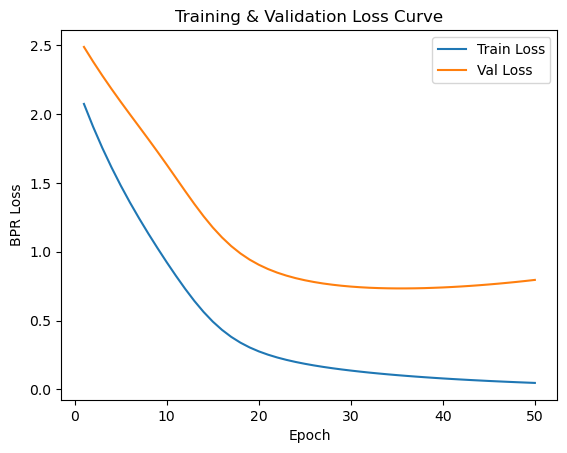

In [ ]:
epochs = 3
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    # ——— train ———
    mf.train()
    tot_train = 0.0
    for user, pos, neg in train_loader:
        user, pos, neg = user.to(device), pos.to(device), neg.to(device)
        optimizer.zero_grad()
        loss = bpr_loss(mf(user, pos), mf(user, neg))
        loss.backward()
        optimizer.step()
        tot_train += loss.item()
    avg_train = tot_train / len(train_loader)
    train_losses.append(avg_train)

    # ——— val ———
    mf.eval()
    tot_val = 0.0
    with torch.no_grad():
        for user, pos, neg in val_loader:
            user, pos, neg = user.to(device), pos.to(device), neg.to(device)
            tot_val += bpr_loss(mf(user, pos), mf(user, neg)).item()
    avg_val = tot_val / len(val_loader)
    val_losses.append(avg_val)

    print(f"Epoch {epoch}/{epochs} — Train: {avg_train:.4f}, Val: {avg_val:.4f}")

# Cell 6: plot curves
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("BPR Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

### Evaluation Procedure

#### 1. Metrics definitions
- **Hit@K**  
  Returns 1 if the true (positive) item is ranked $\le K$, else 0.
- **NDCG@K**  
  Returns $\displaystyle \frac{1}{\log_{2}(\mathrm{rank}+1)}$ if $\mathrm{rank}\le K$, else 0.
- **MRR** (Mean Reciprocal Rank)  
  $\displaystyle \mathrm{MRR} = \frac{1}{\mathrm{rank}}$
- **MAP** (Mean Average Precision)  
  For a single positive item, $\mathrm{AP} = \frac{1}{\mathrm{rank}}$

#### 2. Negative sampling
Given a user prefix (items in train + validation) and the global item set, sample $(\mathrm{candidate\_size} - 1)$ negatives uniformly from items the user hasn’t seen.

#### 3. Per‑user evaluation loop
For each user with at least one test item:  
1. **Build prefix** = `train_seq + val_seq`  
2. **Held‑out positive** = `test_seq[0]`  
3. **Sample negatives** (size = candidate_size – 1) excluding prefix & positive  
4. **Candidates** = `[positive] + negatives`  
5. **Score all candidates** in one forward pass:  
   ```python
   users_t = torch.tensor([user] * candidate_size, dtype=torch.long, device=device)
   items_t = torch.tensor(candidates,         dtype=torch.long, device=device)
   scores  = model(users_t, items_t).cpu().numpy()

In [202]:
metrics = evaluate_ranking_model(
    model=mf,
    user_splits=user_splits,
    global_items=all_movies,
    device=device,
    candidate_size=100,
    k=10
)

print("Evaluation Metrics:")
for name, val in metrics.items():
    print(f"- {name}: {val:.4f}")

Evaluation Metrics:
- Hit@10: 0.3688
- NDCG@10: 0.1803
- MRR: 0.1505
- MAP: 0.1505


Lets see which movies are similar to toy story

In [ ]:
from torch.nn import functional as F
toy_story_emb = mf.item_embeddings.weight[0]               # shape: [32]   
item_embs = F.normalize(mf.item_embeddings.weight, dim=1)  # shape: [3883, 32]
toy_story_emb = toy_story_emb / toy_story_emb.norm()       # shape: [32]
similarities = item_embs @ toy_story_emb  # shape: [3883]
# Step 4: Get top-k most similar item indices (excluding itself if needed)
topk = torch.topk(similarities, k=10 + 1)
indices = topk.indices.tolist()
# Look them up in the movies DataFrame
similar_movies_df = movies[movies['MovieID'].isin(indices)]
# Optional: Sort by similarity score
scores = similarities[indices].tolist()
similar_movies_df['similarity'] = scores
similar_movies_df = similar_movies_df.sort_values(by='similarity', ascending=False)

print(similar_movies_df[['MovieID', 'Title', 'similarity']])

      MovieID                                              Title  similarity
0           0                                   Toy Story (1995)    1.000000
33         33                                        Babe (1995)    0.815856
1178     1178  Star Wars: Episode V - The Empire Strikes Back...    0.785615
1179     1179                         Princess Bride, The (1987)    0.761110
1250     1250                          Back to the Future (1985)    0.745720
1373     1373                             Raising Arizona (1987)    0.742046
1683     1683                           Big Lebowski, The (1998)    0.740851
1854     1854                There's Something About Mary (1998)    0.739964
1959     1959                         Saving Private Ryan (1998)    0.729612
2789     2789                             American Beauty (1999)    0.725672
3045     3045                                 Toy Story 2 (1999)    0.724703


/var/folders/pt/4cr2zr794g717_kmql57h7qw0000gn/T/ipykernel_67461/2216239250.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_movies_df['similarity'] = scores


## Fancier matrix factorization

We're now going to use an MLP instead of dot product. This brings us into deepMF territory. The set up is nearly identical so we can reuse the same data objects as before.

Epoch 1/5 | Train Loss: 0.4711 | Val Loss: 0.4227
Epoch 2/5 | Train Loss: 0.3053 | Val Loss: 0.3844
Epoch 3/5 | Train Loss: 0.2851 | Val Loss: 0.3741
Epoch 4/5 | Train Loss: 0.2780 | Val Loss: 0.3758
Epoch 5/5 | Train Loss: 0.2737 | Val Loss: 0.3733


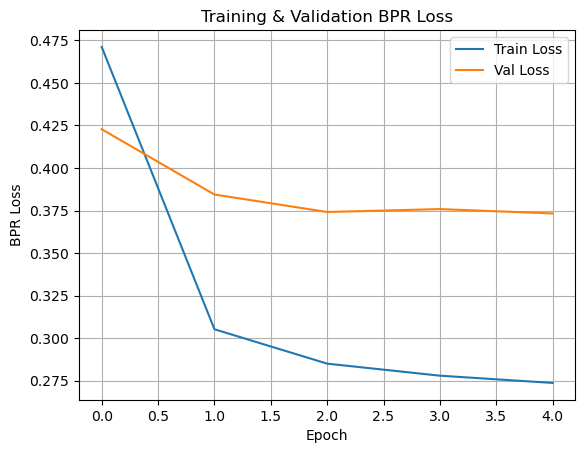

In [ ]:
emb_dim = 32

train_losses, val_losses = [], []
model = DeepMF(num_users, num_items, emb_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 3

for epoch in range(epochs):
    # --- Training ---
    model.train()
    total_train_loss = 0.0

    for user, pos, neg in train_loader:
        user, pos, neg = user.to(device), pos.to(device), neg.to(device)

        optimizer.zero_grad()
        pos_score = model(user, pos)
        neg_score = model(user, neg)

        loss = -F.logsigmoid(pos_score - neg_score).mean()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for user, pos, neg in val_loader:
            user, pos, neg = user.to(device), pos.to(device), neg.to(device)

            pos_score = model(user, pos)
            neg_score = model(user, neg)

            val_loss = -F.logsigmoid(pos_score - neg_score).mean()
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("BPR Loss")
plt.title("Training & Validation BPR Loss")
plt.legend()
plt.grid(True)
plt.show()


In [212]:
from torch.nn import functional as F
toy_story_emb = model.item_embeddings.weight[0]               # shape: [32]   
item_embs = F.normalize(model.item_embeddings.weight, dim=1)  # shape: [3883, 32]
toy_story_emb = toy_story_emb / toy_story_emb.norm()       # shape: [32]
similarities = item_embs @ toy_story_emb  # shape: [3883]
# Step 4: Get top-k most similar item indices (excluding itself if needed)
topk = torch.topk(similarities, k=10 + 1)
indices = topk.indices.tolist()
# Look them up in the movies DataFrame
similar_movies_df = movies[movies['MovieID'].isin(indices)]
# Optional: Sort by similarity score
scores = similarities[indices].tolist()
similar_movies_df['similarity'] = scores
similar_movies_df = similar_movies_df.sort_values(by='similarity', ascending=False)

print(similar_movies_df[['MovieID', 'Title', 'similarity']])

      MovieID                                          Title  similarity
0           0                               Toy Story (1995)    1.000000
114       114                   Anne Frank Remembered (1995)    0.548046
901       901                     Maltese Falcon, The (1941)    0.543904
910       910  Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)    0.538334
1055     1055                        Murder, My Sweet (1944)    0.527369
1324     1324                                  Carrie (1976)    0.496787
1664     1664                              Mouse Hunt (1997)    0.488045
2256     2256                                 Orgazmo (1997)    0.469403
2871     2871                                   Gilda (1946)    0.461813
2971     2971                               Meatballs (1979)    0.460504
3630     3630                                 Starman (1984)    0.460175


/var/folders/pt/4cr2zr794g717_kmql57h7qw0000gn/T/ipykernel_67461/1490599772.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_movies_df['similarity'] = scores


# Now lets add features to deepMF

Wrap the model in a scorer. This way the evaluation pipeline doesn't need to reason about features.
